In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline

torch.set_default_dtype(torch.float64)

from sklearn.metrics import r2_score
import dill

import scipy
from sklearn.linear_model import LinearRegression, Ridge

In [2]:
# 20160630

# z_train_filter = np.load('new_params/z_hat_20min_filter.npy')
# plt.plot(z_train_filter[0, :, :100].T)
# plt.show()

# z_train_smooth = np.load('new_params/z_hat_20min_smooth.npy')
# plt.plot(z_train_smooth[0, :, :100].T)
# plt.show()

In [3]:
# dataset = '4g10'
dataset = 'Doherty'
datapath = 'processed_data_64.pickled'
smoothing = True
new = False
z_train = None
if dataset == '4g10':
    data = np.load('data_10ms.npz')
    v_train = Tensor(data['hand_train'].transpose(1,0,2))
    v_test = Tensor(data['hand_test'].transpose(1,0,2))
    Y_train = Tensor(data['neural_train'].transpose(1,0,2))
    Y_test = Tensor(data['neural_test'].transpose(1,0,2))
    print(v_train.shape, v_test.shape, Y_train.shape, Y_test.shape)
    T_trial = 0.01 # 10ms

    p = pickle.load(open('4g10preprocess/10ms.pkl', 'rb'))
    # rec_model = dill.load(open('4g10datamodels/first_10ms_rec.pkl', 'rb'))
    m = dill.load(open('4g10datamodels/first_10ms.pkl', 'rb'))
    rec_model = dill.load(open('4g10datamodels/first_10ms_rec_online.pkl', 'rb'))
    gen_model = rec_model.gen_model

elif dataset == 'Doherty':
    p = pickle.load(open('new_params/_1t.pkl', 'rb'))
    z_train = np.load('new_params/z_hat_20min_smooth.npy')

    # p = pickle.load(open('new_params/9k1t.pkl', 'rb'))
    # m = dill.load(open('bgpfa_models/shifted.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/shifted_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/9k.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9k_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/9ktrain_5kpre.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_rec_CD.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/9ktrain_5kpreNB.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_NB_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_NB_CD_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/9ktrain_5kpre_NB_new_CD_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/320NB.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_CD_AB_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_CD_ABp_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_CD_ABp_smallrnn_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/320NB_400t.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_400t_CD_ABp_rec.pkl', 'rb'))
    
    # m = dill.load(open('bgpfa_models/gen_train.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/gen_train_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/320NB_filt.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/320NB_filt_rec.pkl', 'rb'))
    
    # p = pickle.load(open('new_params/5k_20z.pkl', 'rb'))
    # z_train = np.load('new_params/z_hat_5k_20z.npy')
    # # m = dill.load(open('bgpfa_models/5k_20z.pkl', 'rb'))
    # # # rec_model = dill.load(open('bgpfa_models/5k_20z_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/20z.pkl', 'rb'))
    # # rec_model = dill.load(open('bgpfa_models/20z_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/20z_long_rec.pkl', 'rb'))

    # rec_model = dill.load(open('bgpfa_models/5k_20z_rec_new.pkl', 'rb'))
    new = True
    

    # p = pickle.load(open('new_params/5k_30z.pkl', 'rb'))
    # z_train = np.load('new_params/z_hat_5k_30z.npy')
    # m = dill.load(open('bgpfa_models/5k_30z.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_30z_rec.pkl', 'rb'))

    # p = pickle.load(open('new_params/_1t.pkl', 'rb'))
    # z_train = np.load('new_params/z_hat_20min_smooth.npy')

    # m = dill.load(open('bgpfa_models/5k_10z_notshifted.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_notshifted_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/5k_10z_notshifted_noCD.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_notshifted_noCD_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/5k_10z_notshifted_poisson_noCD.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_notshifted_poisson_noCD_rec_best.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/5k_10z_poisson_noCD2.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_poisson_noCD_rec2.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/5k_10z_NB_noCD.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_NB_noCD_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/5k_10z_NB_CDnew.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_NB_CDnew_rec.pkl', 'rb'))

    train_r2_available = True
    # m = dill.load(open('bgpfa_models/5k_10z_NB_CDnewLSTM.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_NB_CDnewLSTM_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/5k_10z_NB_newLSTM_oldCD.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_NB_newLSTM_newCD_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/5k_10z_NB_newLSTM.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5k_10z_NB_newLSTM_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/no_init.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/no_init_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/NB_co.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/NB_co_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/NB_co_long.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/NB_co_long_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/NB_co_bi.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/NB_co_bi_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/NB_co_long_bi.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/NB_co_long_bi_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/NB_co_long_bi_new.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/NB_co_long_bi_new_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/NB_co_long_bi_newCD_rec_best.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/no_init_long.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/no_init_long_rec.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/NB_co_long_bi_new_small_x.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/NB_co_long_bi_small_x_rec.pkl', 'rb'))
    
    # p = pickle.load(open('new_params/5k_5z_new.pkl', 'rb'))
    # z_train = np.load('new_params/z_hat_20min_smooth.npy')
    # m = dill.load(open('bgpfa_models/5z.pkl', 'rb'))
    # # rec_model = dill.load(open('bgpfa_models/5z_rec.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/5z_long_rec.pkl', 'rb'))

    # p = pickle.load(open('new_params/5k_15z.pkl', 'rb'))
    # z_train = np.load('new_params/z_hat_20min_smooth.npy')
    # m = dill.load(open('bgpfa_models/15z.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/15z_rec_best.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/15z_long_rec.pkl', 'rb'))

    # p = pickle.load(open('new_params/5k_2z.pkl', 'rb'))
    # z_train = np.load('new_params/z_hat_20min_smooth.npy')
    # m = dill.load(open('bgpfa_models/2z_zv.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/2z_zv_rec_best.pkl', 'rb'))

    # m = dill.load(open('bgpfa_models/10z.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/10z_rec.pkl', 'rb'))
    
    # m = dill.load(open('bgpfa_models/10z_400t.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/10z_400t_rec.pkl', 'rb'))

    p = pickle.load(open('new_params/64ms_10z_2k.pkl', 'rb'))
    m = dill.load(open('bgpfa_models/64ms_10z.pkl', 'rb'))
    # rec_model = dill.load(open('bgpfa_models/64ms_10z_rec.pkl', 'rb'))
    rec_model = dill.load(open('bgpfa_models/64ms_10z_filt_rec.pkl', 'rb'))

    gen_model = rec_model.gen_model

    # data_len = 48800
    # data_len = 69800
    data_len = 22800
    # data_len = 20000
    trial_len = rec_model.gen_model.Y.shape[-1]
    train_len = 12800
    # train_len = 5000
    # test_trial_len = data_len - train_len
    test_trial_len = 1000

    if not datapath:
        data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
        binsize = 25 # binsize in ms
        T_trial = 0.025 # 25ms
        start = 0
        timepoints = np.arange(start, data_len+start) #subsample ~40 seconds of data so things will run somewhat quicker
        # print(data['Y'].shape)
        fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
        Y = fit_data['Y'] # these are the actual recordings and is the input to our model
        targets = fit_data['targets'] # these are the target locations
        locs = fit_data['locs'] # these are the hand positions

        # Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 2, :] #subsample highly active neurons so things will run a bit quicker
        Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 0, :]
        # print(Y.shape)
        ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]

        ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
        cs = CubicSpline(ts, locs) # fit cubic spline to behavior
        delay = 120
        vels = cs(ts+delay, 1) # velocity (first derivative)
        v = Tensor(vels.T[None, ...])
    else:
        data_len = 10000
        train_len = 5000
        binsize = 64 # binsize in ms
        T_trial = 0.064 # 25ms
        data = pickle.load(open(datapath, 'rb'))
        start = 0
        timepoints = np.arange(start, data_len)
        Y = data['Y'][..., timepoints]
        Y = Y[:, np.load('active_neurons.npy'), :]
        vels = data['vels'][timepoints]
        v = Tensor(vels.T[None, ...])
        print('v shape loaded', v.shape)
        print('Y shape loaded', Y.shape)
        ntrials, n, T = Y.shape


    def convert_to_trials(_Y, _z=None, _v=None, t=None):
        assert _Y.shape[-1] % t == 0
        N = _Y.shape[1]
        ntrials = _Y.shape[-1] // t
        Y = _Y.transpose(1,0,2).reshape(N,ntrials,-1).transpose(1,0,2)
        z = None
        if _z is not None:
            b = _z.shape[1]
            z = _z.transpose(1,0,2).reshape(b,ntrials,-1).transpose(1,0,2)
        v = None
        if _v is not None:
            b_v = _v.shape[1]
            v = _v.permute(1,0,2).reshape(b_v,ntrials,-1).permute(1,0,2)
        return Y, z, v

    print(Y.shape, 'original Y shape')
    Y_train = Y[..., :train_len]
    # z_train = z[..., :train_len]
    v_train = v[..., :train_len]
    Y_test = Y[..., train_len:]
    # z_test = z[..., train_len:]
    v_test = v[..., train_len:]

    if z_train is None:
        z_train = p.get_z_hat(v_train).detach().cpu().numpy()
    z_train = z_train[:,:,:train_len]

    Y_train, z_train, v_train = convert_to_trials(Y_train, z_train, v_train, trial_len)
    Y_test, _, v_test = convert_to_trials(Y_test, None, v_test, test_trial_len)
    Y_train = Tensor(Y_train)
    Y_test = Tensor(Y_test)
    print(Y_train.shape, v_train.shape, 'y_train, v_train shape')
    print(Y_test.shape, v_test.shape, 'y_test, v_test shape')

    Y_train_flat = Y_train.permute(1,0,2).reshape(n, -1).unsqueeze(0)
    Y_test_flat = Y_test.permute(1,0,2).reshape(n, -1).unsqueeze(0)

    print(Y_train_flat.shape, Y_test_flat.shape, 'y train flat, y test flat shape')

if not hasattr(rec_model, 'train_neurons'):
    rec_model.train_neurons = None

v shape loaded torch.Size([1, 2, 10000])
Y shape loaded (1, 200, 10000)
(1, 200, 10000) original Y shape
torch.Size([50, 200, 100]) torch.Size([50, 2, 100]) y_train, v_train shape
torch.Size([5, 200, 1000]) torch.Size([5, 2, 1000]) y_test, v_test shape
torch.Size([1, 200, 5000]) torch.Size([1, 200, 5000]) y train flat, y test flat shape


In [4]:
print(rec_model.neural_net)

MyLSTMModel(
  (lstm): LSTM(180, 180, batch_first=True)
  (fc): Linear(in_features=180, out_features=10, bias=True)
)


In [5]:
print(rec_model.preprocessor.v.shape)

torch.Size([50, 2, 100])


In [6]:
# plt.plot(v_test[:,0,:].flatten())
# plt.plot(v_test[:,1,:].flatten())
# plt.show()

# plt.plot(torch.mean(Y_test, axis=1).flatten())

In [7]:
# z_train_filter = p.get_z_hat(v_train, smoothing=True).detach().cpu().numpy()
# print(z_train_filter.shape)
# np.save('new_params/z_hat_5k_30z.npy', z_train_filter)

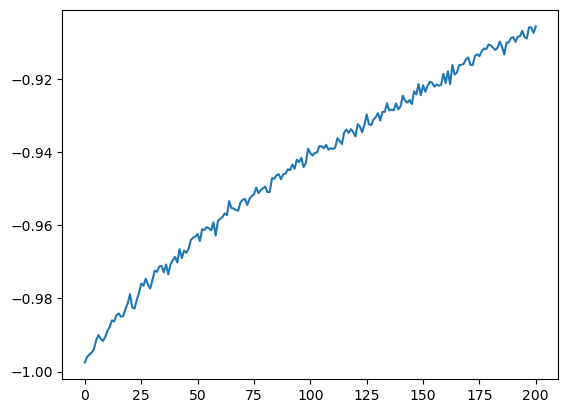

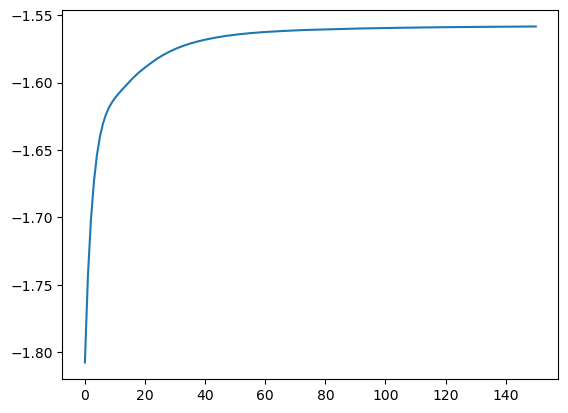

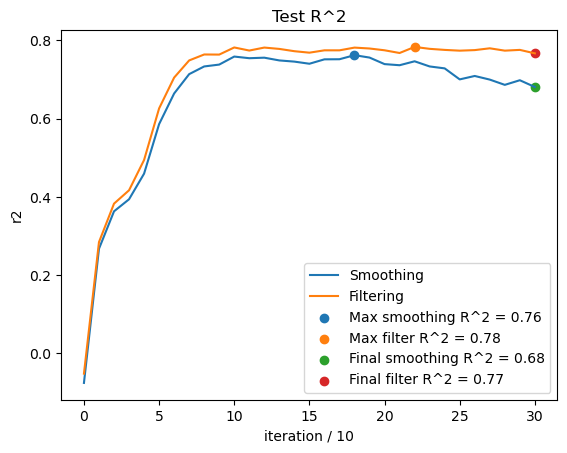

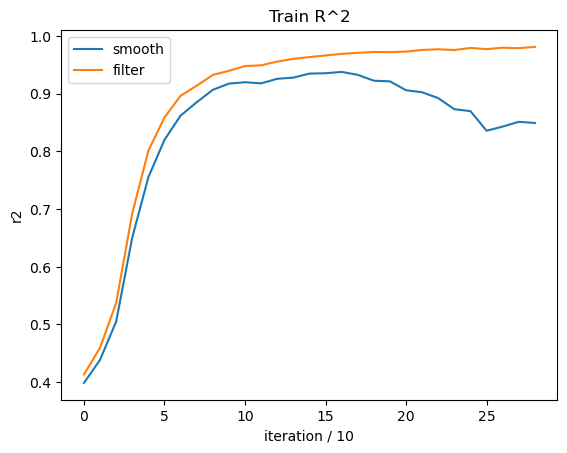

-0.955652829430594 -0.9337990171281074
-0.955652829430594 -0.932328062591104 max co smooth


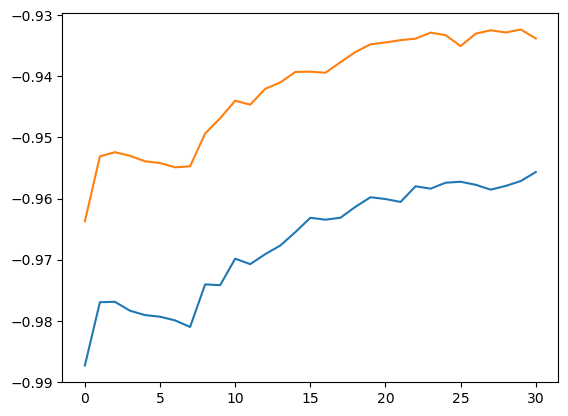

Final LL = -0.9057214457919167
0.6995448633846553 0.6620506883644983 0.6807977758745768 final r2
0.807025188437545 0.7538321344671955 0.7621503490610777 max r2


In [8]:
plt.plot(rec_model.LLs[100:])
plt.show()
plt.plot(gen_model.LLs[:])
plt.show()

# if new:
if hasattr(rec_model, 'r2_smooth'):
    start = 0
    plt.plot(rec_model.r2_smooth[start:], label='Smoothing')
    plt.plot(rec_model.r2_filt[start:], label='Filtering')

    max_r2 = np.max(rec_model.r2_smooth[start:])
    max_r2_idx = np.argmax(rec_model.r2_smooth[start:])
    plt.scatter(max_r2_idx, max_r2, label=f'Max smoothing R^2 = {max_r2:.2f}')
   
    max_r2 = np.max(rec_model.r2_filt[start:])
    max_r2_idx = np.argmax(rec_model.r2_filt[start:])
    plt.scatter(max_r2_idx, max_r2, label=f'Max filter R^2 = {max_r2:.2f}')

    # Plot the last R^2 value
    plt.scatter(len(rec_model.r2_smooth)-start-1, rec_model.r2_smooth[-1], label=f'Final smoothing R^2 = {rec_model.r2_smooth[-1]:.2f}')
    plt.scatter(len(rec_model.r2_filt)-start-1, rec_model.r2_filt[-1], label=f'Final filter R^2 = {rec_model.r2_filt[-1]:.2f}') 



    plt.legend()
    plt.xlabel('iteration / 10')
    plt.ylabel('r2')
    plt.title('Test R^2')
    plt.show()

# if train_r2_available:
if hasattr(rec_model, 'r2_smooth_train'):
    start = 2
    plt.plot(rec_model.r2_smooth_train[start:], label='smooth')
    plt.plot(rec_model.r2_filt_train[start:], label='filter')
    plt.legend()
    plt.xlabel('iteration / 10')
    plt.ylabel('r2')
    plt.title('Train R^2')
    plt.show()

if hasattr(rec_model, 'train_co_smoothing_vals'):
    plt.plot(rec_model.train_co_smoothing_vals, label='train')
    plt.plot(rec_model.test_co_smoothing_vals, label='test')
    print(rec_model.train_co_smoothing_vals[-1], rec_model.test_co_smoothing_vals[-1])
    print(np.max(rec_model.train_co_smoothing_vals), np.nanmax(rec_model.test_co_smoothing_vals), 'max co smooth')
    # plt.ylim(-0.55, -0.52)
    plt.show()

print('Final LL =', rec_model.LLs[-1])
if hasattr(rec_model, 'r2_smooth_train'):
    print(rec_model.r2x_smooth[-1], rec_model.r2y_smooth[-1], rec_model.r2_smooth[-1], 'final r2')
    print(np.max(rec_model.r2x_smooth), np.max(rec_model.r2y_smooth), np.max(rec_model.r2_smooth), 'max r2')

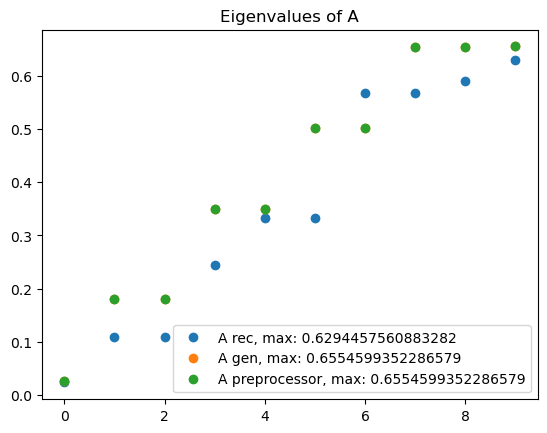

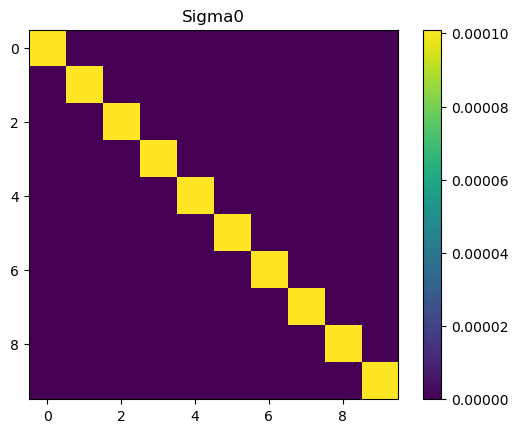

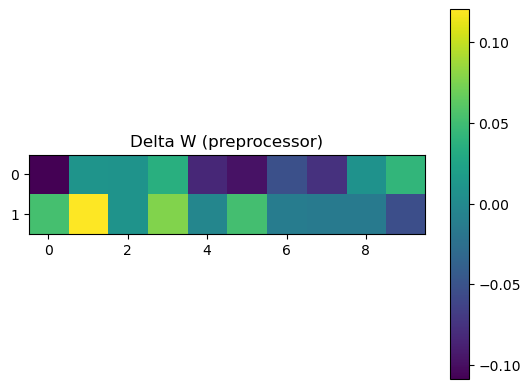

tensor([[ 1.2773e-04, -1.1121e-05],
        [-1.1121e-05,  7.7805e-05]], device='cuda:0', grad_fn=<AddBackward0>) tensor([[ 4.3007e-05, -1.3115e-05],
        [-1.3115e-05,  2.6724e-05]], device='cuda:0')


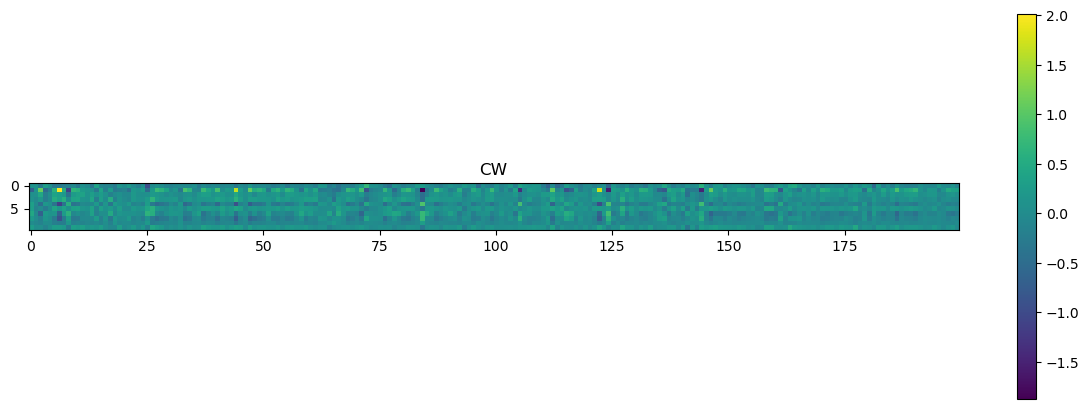

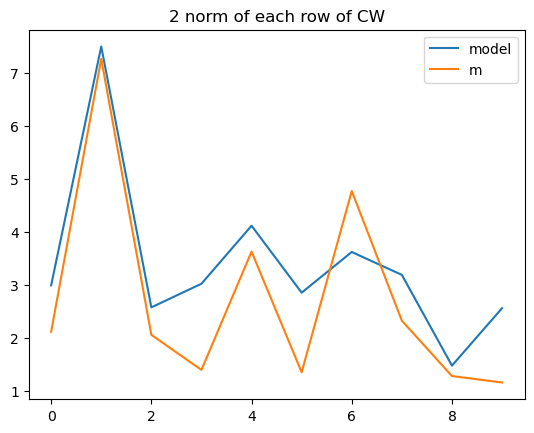

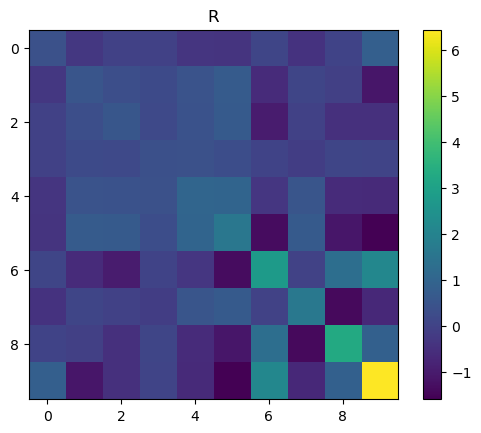

Text(0, 0.5, 'd')

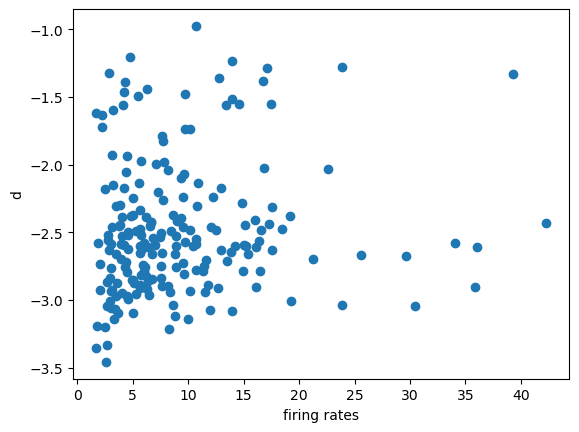

In [9]:
eigs = sorted(np.abs(np.linalg.eigvals(gen_model.A[0].detach().cpu().numpy())))
plt.plot(eigs, 'o', label='A rec, max: {}'.format(np.max(eigs)))
eigs = sorted(np.abs(np.linalg.eigvals(m.A[0].detach().cpu().numpy())))
plt.plot(eigs, 'o', label='A gen, max: {}'.format(np.max(eigs)))
eigs = sorted(np.abs(np.linalg.eigvals(p.A.detach().cpu().numpy())))
plt.plot(eigs, 'o', label='A preprocessor, max: {}'.format(np.max(eigs)))
plt.legend()
plt.title('Eigenvalues of A')
plt.show()

plt.imshow(p.Sigma0.detach().cpu().numpy())
plt.colorbar()
plt.title('Sigma0')
plt.show()
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(rec_model.preprocessor.W.detach().cpu().numpy())
# ax[0].set_title('W new')
# ax[1].imshow(p.W.detach().cpu().numpy())
# ax[1].set_title('W orig')
# plt.show()
plt.imshow(rec_model.preprocessor.W.detach().cpu().numpy() - p.W.detach().cpu().numpy())
plt.colorbar()
plt.title('Delta W (preprocessor)')
plt.show()

print(rec_model.preprocessor.R, p.R)

# plt.imshow(gen_model.A[0].detach().cpu().numpy() - m.A[0].detach().cpu().numpy())
# plt.colorbar()
# plt.title('Delta A')
# plt.show()

# plt.imshow(gen_model.Q[0].detach().cpu().numpy() - m.Q[0].detach().cpu().numpy())
# plt.colorbar()
# plt.title('Delta Q')
# plt.show()

plt.figure(figsize=(15, 5))  # Adjust as needed
plt.imshow((gen_model.C @ gen_model.W)[0].detach().cpu().numpy().T)
plt.colorbar()
plt.title('CW')
plt.show()

# plt.figure(figsize=(15, 5))  # Adjust as needed
# # m = dill.load(open('4g10datamodels/new_full_R.pkl', 'rb'))
# plt.imshow((m.C @ m.W)[0].detach().cpu().numpy().T)
# plt.colorbar()
# plt.title('CW (orig gen model)')
# plt.show()

# plt.figure(figsize=(15, 5))  # Adjust as needed
# plt.imshow((m.C @ m.W)[0].detach().cpu().numpy().T - (gen_model.C @ gen_model.W)[0].detach().cpu().numpy().T)
# plt.colorbar()
# plt.title('CW delta')
# plt.show()

# plot 2 norm of each row of CW
plt.plot(torch.linalg.norm((gen_model.C @ gen_model.W)[0], dim=0).detach().cpu().numpy(), label='model')
plt.plot(torch.linalg.norm((m.C @ m.W)[0], dim=0).detach().cpu().numpy(), label='m')
plt.legend()
plt.title('2 norm of each row of CW')
plt.show()

plt.imshow(gen_model.R.squeeze(0).detach().cpu().numpy())
plt.colorbar()
plt.title('R')
plt.show()

# # plot Delta R between model and m
# plt.imshow((model.R.squeeze(0) - m.R.squeeze(0)).detach().cpu().numpy())
# plt.colorbar()
# plt.title('Delta R')
# plt.show()

if rec_model.gen_model.R.shape[-1] == rec_model.gen_model.N:
    plt.plot(Y_train.mean(dim=(0,2))/T_trial, torch.diag(gen_model.R.squeeze()).detach().cpu().numpy(), 'o', label='model')
    plt.plot(Y_train.mean(dim=(0,2))/T_trial, torch.diag(m.R.squeeze()).detach().cpu().numpy(), 'o', label='m')
    plt.legend()
    plt.xlabel('firing rates')
    plt.ylabel('var_x')
    plt.show()


plt.plot(Y_train.mean(dim=(0,2))/T_trial, gen_model.d.detach().cpu().numpy(), 'o')
plt.xlabel('firing rates')
plt.ylabel('d')

/home/ayush/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


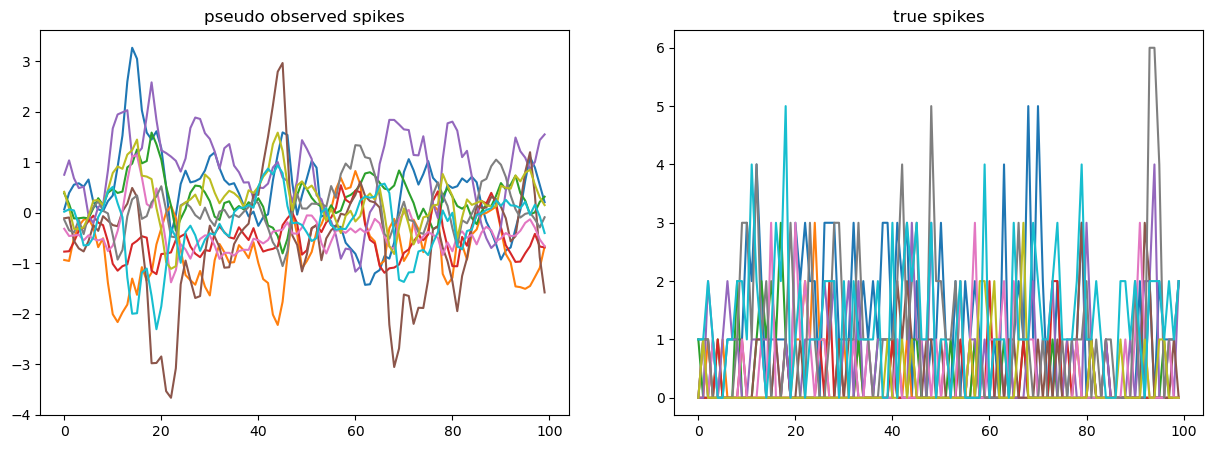

In [10]:
neural_net = rec_model.neural_net
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for n in range(rec_model.gen_model.x_dim):
    if rec_model.train_neurons is not None:
        ax[0].plot(neural_net(rec_model.gen_model.Y[:, rec_model.train_neurons, :].transpose(1, 2)).transpose(1,2)[0, n, :].detach().cpu().numpy())
    else:
        ax[0].plot(neural_net(rec_model.gen_model.Y.transpose(1, 2)).transpose(1,2)[0, n, :].detach().cpu().numpy())
    # ax[0].plot(neural_net(rec_model.gen_model.Y.transpose(1, 2))['x_tilde'].transpose(1,2)[0, n, :].detach().cpu().numpy())
# plt.show()
for n in range(rec_model.gen_model.x_dim):
    ax[1].plot(Y_train[0, n, :].detach().cpu().numpy())   
ax[0].set_title('pseudo observed spikes')
ax[1].set_title('true spikes')
plt.show()

In [11]:
rec_model.freeze_params()
print(smoothing)
torch.cuda.empty_cache()
if rec_model.train_neurons is not None:
    np.random.seed(0)
    torch.manual_seed(0)
    z_train_inferred, z_train_inferred_samps = rec_model.test_z(rec_model.gen_model.Y, smoothing=smoothing, samples=100, batch=10, train_indices=rec_model.train_neurons)
else:
    np.random.seed(0)
    torch.manual_seed(0)
    z_train_inferred = rec_model.test_z(rec_model.gen_model.Y, smoothing=smoothing, samples=0, batch=10)
torch.cuda.empty_cache()

if rec_model.train_neurons is not None:
    z_test_inferred, z_test_inferred_samps = rec_model.test_z(Y_test.to(device), smoothing=smoothing, samples=100, batch=10, train_indices=rec_model.train_neurons)
else:
    z_test_inferred = rec_model.test_z(Y_test.to(device), smoothing=smoothing, samples=0, batch=10)


torch.cuda.empty_cache()
print(z_train_inferred.shape, z_test_inferred.shape, 'z_train_inferred, z_test_inferred shape')

v_train_inferred = (rec_model.preprocessor.W.detach().cpu().numpy() @ z_train_inferred)
v_test_inferred = (rec_model.preprocessor.W.detach().cpu().numpy() @ z_test_inferred)
print(v_train_inferred.shape, v_test_inferred.shape, 'v_train_inferred, v_test_inferred shape')


True
(50, 10, 100) (5, 10, 1000) z_train_inferred, z_test_inferred shape
(50, 2, 100) (5, 2, 1000) v_train_inferred, v_test_inferred shape


In [12]:
if dataset == 'Doherty':
    _nsamps, _ntrials, _N, _T = z_train_inferred_samps.shape
    z_train_inferred_samps = z_train_inferred_samps.transpose(0,2,1,3).reshape((_nsamps, _N, _T*_ntrials))[:, None, ...]

    _nsamps, _ntrials, _N, _T = z_test_inferred_samps.shape
    z_test_inferred_samps = z_test_inferred_samps.transpose(0,2,1,3).reshape((_nsamps, _N, _T*_ntrials))[:, None, ...]

    print(z_train_inferred_samps.shape, z_test_inferred_samps.shape)

(100, 1, 10, 5000) (100, 1, 10, 5000)


In [13]:
# zz_dim = 2
# train_start = 1200
# train_end = 1600

# for zz in range(10):
#     for s in range(z_test_inferred_samps.shape[0]):
#         plt.plot(z_train_inferred_samps[s, :, zz, :].flatten()[train_start:train_end], alpha=0.1)
#     plt.plot(z_train_inferred[:, zz, :].flatten()[train_start:train_end], label='inferred')
#     plt.plot(z_train_inferred_samps[:, :, zz, :].mean(axis=0).flatten()[train_start:train_end], label='sample mean')
#     # plt.plot(z_train_inferred_samps[:, 0, zz, :100].T, alpha=0.1)
#     plt.legend()
#     plt.title('Train')
#     plt.show()

# plt.plot(z_test_inferred[0, zz_dim, :100], label='inferred')
# plt.plot(z_test_inferred_samps[:, 0, zz_dim, :100].T, alpha=0.1)
# plt.plot(z_test_inferred_samps[:, 0, zz_dim, :100].mean(axis=0), label='sample mean')
# plt.legend()
# plt.title('Test')
# plt.show()

# # fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# # ax[0].plot(z_train_inferred[0, :, :100].T)
# # ax[0].set_title('Train inferred')
# # ax[1].plot(z_train_inferred_samps[:, 0, :, :100].mean(axis=0).T)
# # ax[1].set_title('Train inferred sample mean')
# # plt.show()

# # plt.plot(z_train_inferred[0, :, :100].T)
# # # plt.plot(z_train_inferred_samps[:, 0, :, :100].T, alpha=0.1)
# # plt.plot(z_train_inferred_samps[:, 0, :, :100].mean(axis=0).T, linestyle='--')
# # plt.show()

In [14]:
if dataset == 'Doherty':
    F_bgpfa = np.load('bgpfa_firing_rates.npy')
    F = rec_model.get_firing_rates(z_train_inferred_samps)[0].numpy()

    F_test = rec_model.get_firing_rates(z_test_inferred_samps)[0].numpy()

In [15]:

# F_other_train = np.load('NB_co_long_bi_new_rec_firing_rates_train.npy')
# F_other_test = np.load('NB_co_long_bi_new_rec_firing_rates_test.npy')

F_other_train = np.load('NB_co_long_bi_newCD_rec_firing_rates_train.npy')
F_other_test = np.load('NB_co_long_bi_newCD_rec_firing_rates_test.npy')

# F_train = np.load('2z_zv_rec_firing_rates_train.npy')
# F_test = np.load('2z_zv_rec_firing_rates_test.npy')

In [16]:
# np.save('NB_co_long_bi_new_rec_firing_rates_train.npy', F)
# np.save('NB_co_long_bi_new_rec_firing_rates_test.npy', F_test)

# np.save('NB_co_long_bi_newCD_rec_firing_rates_train.npy', F)
# np.save('NB_co_long_bi_newCD_rec_firing_rates_test.npy', F_test)

# np.save('2z_zv_rec_firing_rates_train.npy', F)
# np.save('2z_zv_rec_firing_rates_test.npy', F_test)

# np.save('15z_rec_firing_rates_train.npy', F)
# np.save('15z_rec_firing_rates_test.npy', F_test)

# np.save('5z_rec_firing_rates_train.npy', F)
# np.save('5z_rec_firing_rates_test.npy', F_test)

# np.save('20z_rec_firing_rates_train.npy', F)
# np.save('20z_rec_firing_rates_test.npy', F_test)

# np.save('15z_rec_best_firing_rates_test.npy', F_test)

In [17]:
np.random.seed(0)
indices = np.random.choice(200, 20, replace=False)
bgpfa_indices = np.load('bgpfa_neuron_indeces.npy')

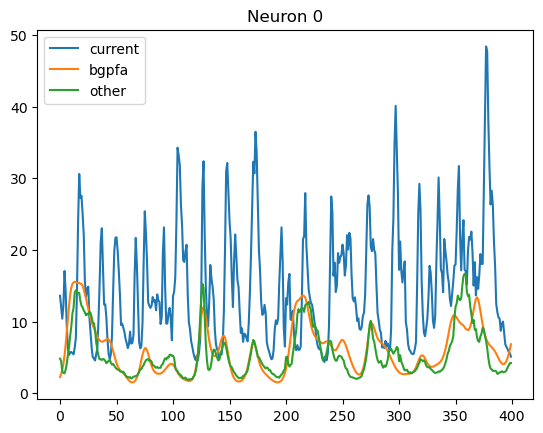

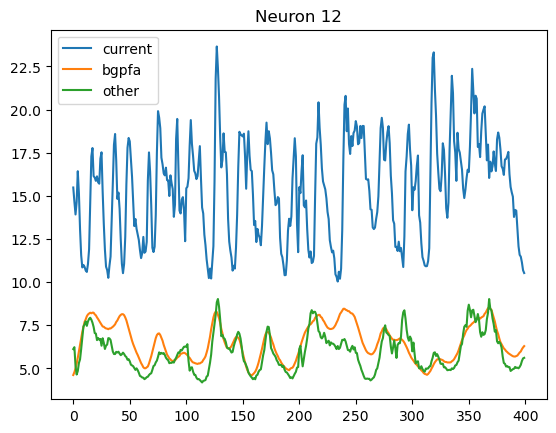

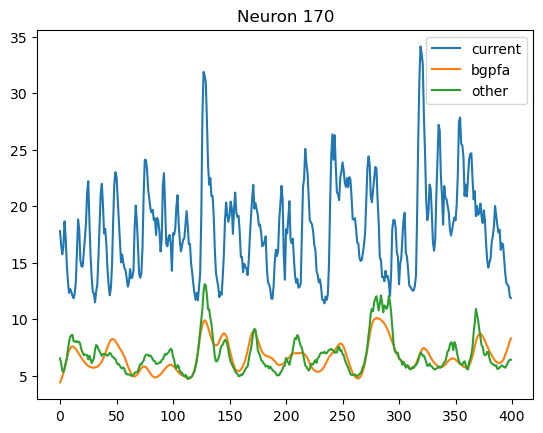

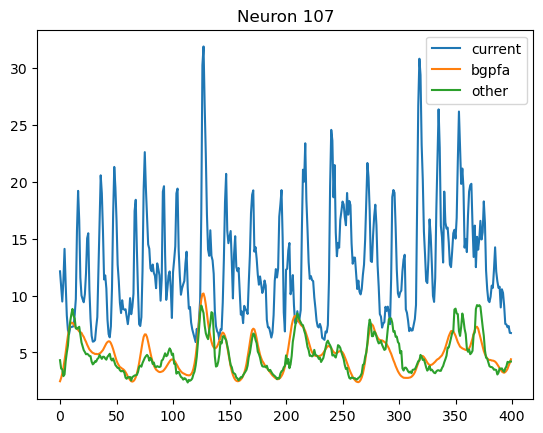

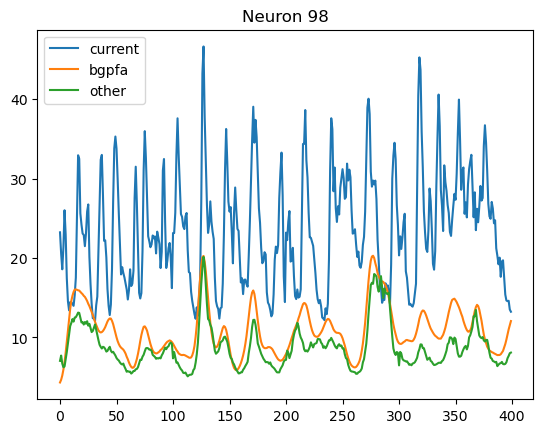

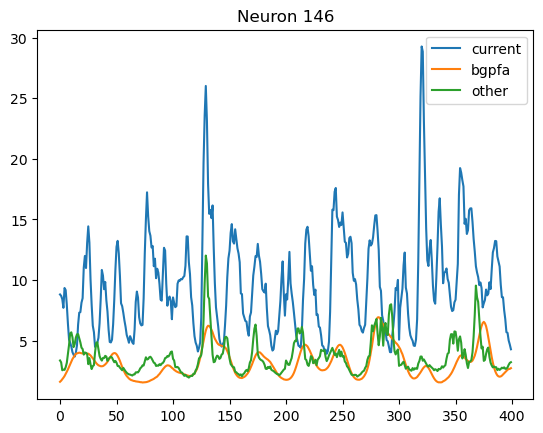

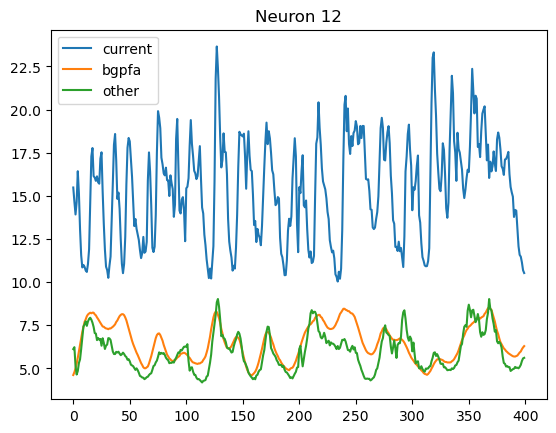

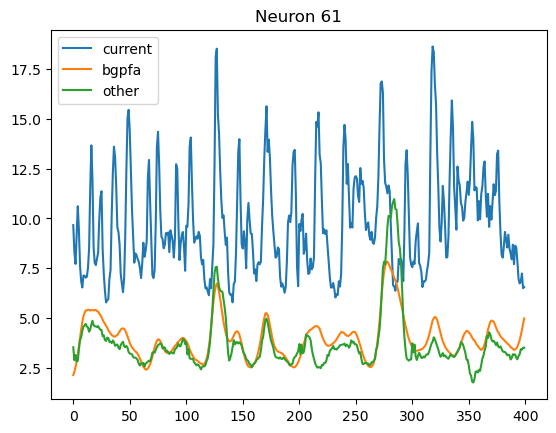

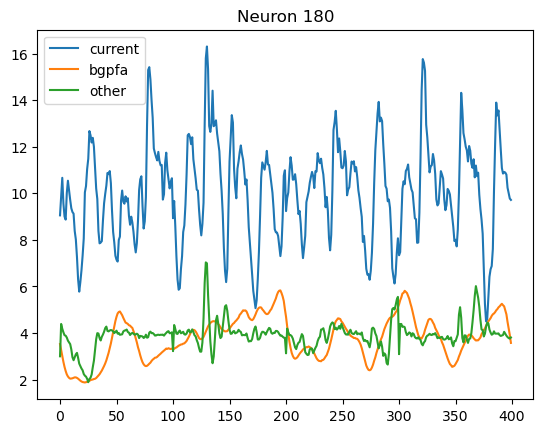

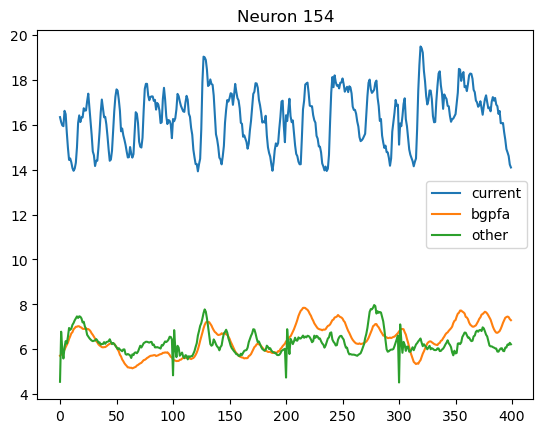

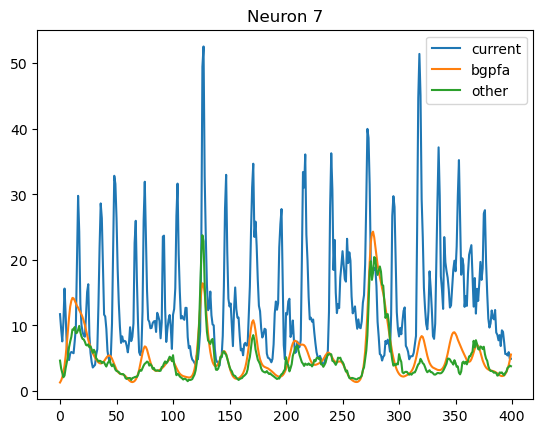

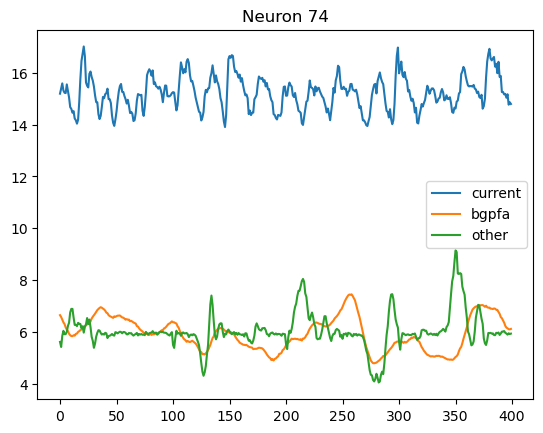

In [18]:
if dataset == 'Doherty':
    bgpfa_indices = np.load('bgpfa_neuron_indeces.npy')
    start =1200
    end = start+400
    for neuron in [0,12]:
        _F = F[:, neuron, :].flatten()
        plt.plot(_F[start:end]/T_trial, label='current')
        bgpfa_neuron = np.where(bgpfa_indices == neuron)[0][0]
        plt.plot(F_bgpfa[0, bgpfa_neuron, start:end]/T_trial, label='bgpfa')
        plt.plot(F_other_train[:, neuron, start:end].flatten()/T_trial, label='other')
        plt.title(f'Neuron {neuron}')
        plt.legend()
        plt.show()

    for neuron in indices:
        if neuron not in bgpfa_indices:
            continue
        bgpfa_neuron = np.where(bgpfa_indices == neuron)[0][0]
        _F = F[:, neuron, :].flatten()
        plt.plot(_F[start:end]/T_trial, label='current')
        plt.plot(F_bgpfa[0, bgpfa_neuron, start:end]/T_trial, label='bgpfa')
        plt.plot(F_other_train[:, neuron, start:end].flatten()/T_trial, label='other')
        plt.title(f'Neuron {neuron}')
        plt.legend()
        plt.show()
    # print(rec_model.co_smoothing(Y_train_flat, Tensor(F))[0])

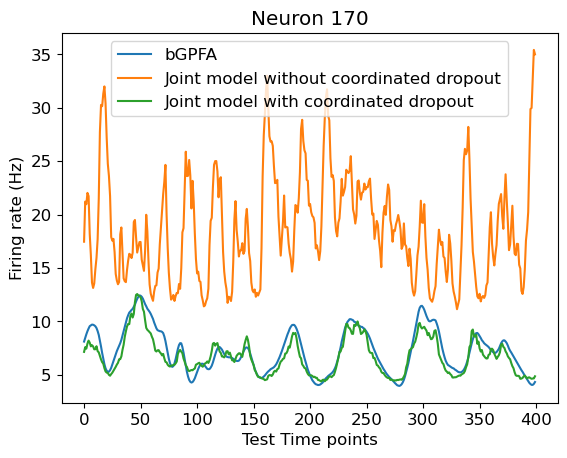

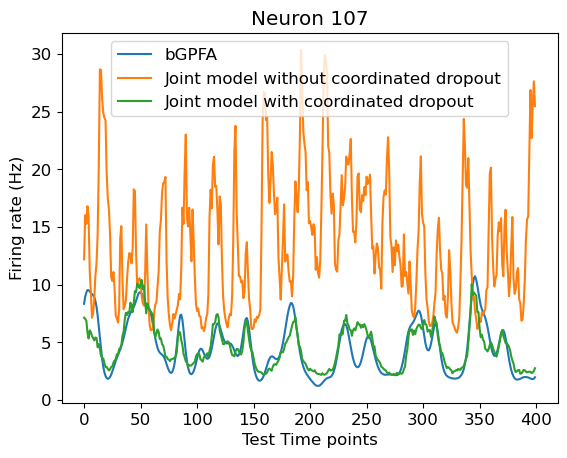

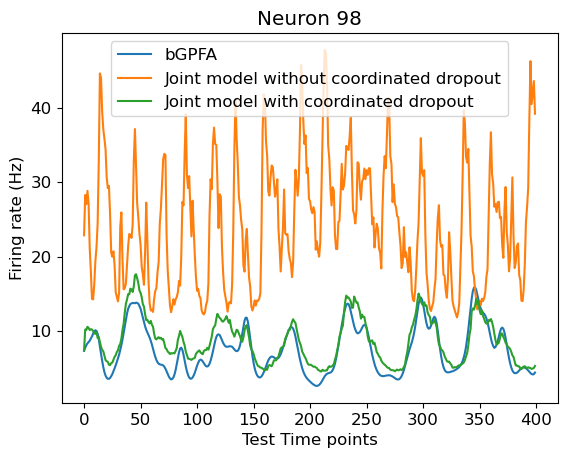

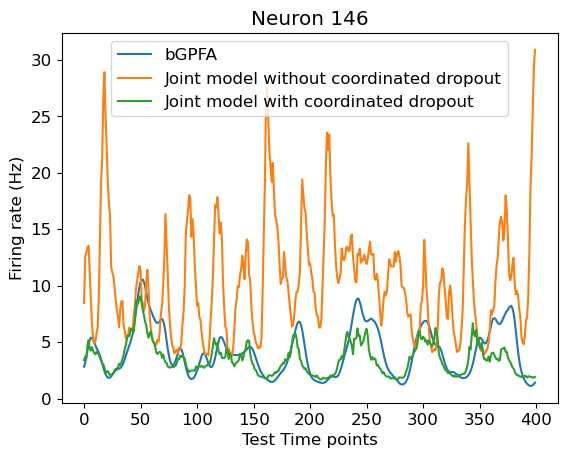

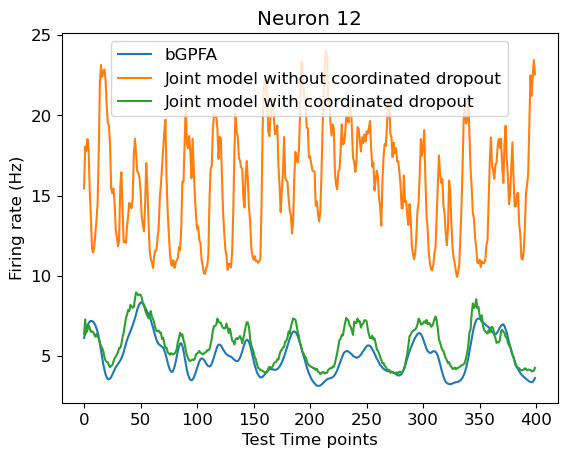

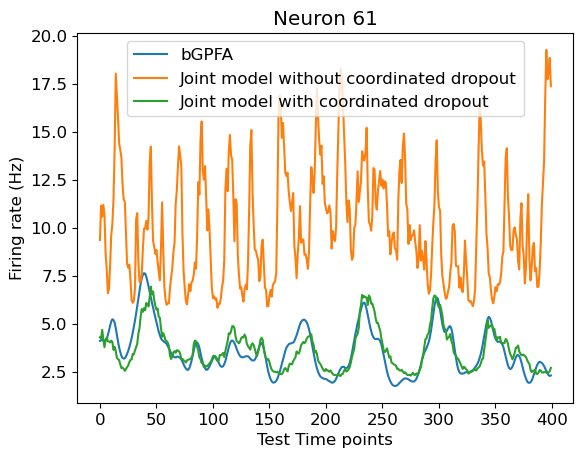

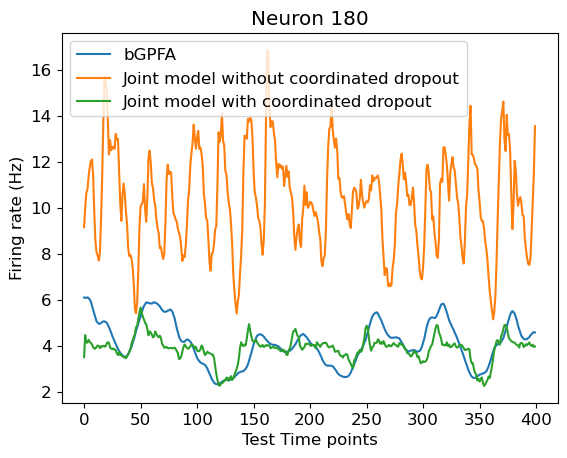

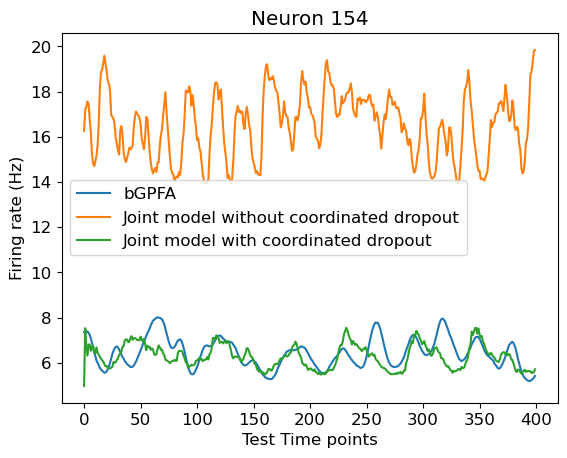

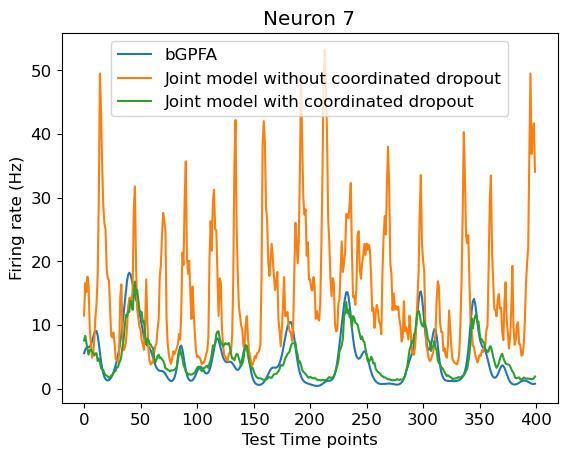

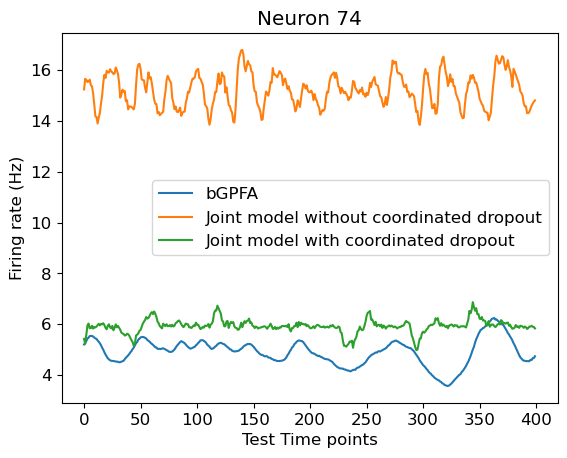

In [19]:
if dataset == 'Doherty':
    F_bgpfa_test = np.load('bgpfa_firing_rates2.npy')
    F_bgpfa_test = F_bgpfa_test[..., 2800:]
    start = 0
    end = start + 400
    plt.rcParams['font.size'] = 12
    for neuron in indices:
        if neuron not in bgpfa_indices:
            continue
        bgpfa_neuron = np.where(bgpfa_indices == neuron)[0][0]
        _F = F_test[:, neuron, :].flatten()
        plt.plot(F_bgpfa_test[0, bgpfa_neuron, start:end]/T_trial, label='bGPFA')
        plt.plot(_F[start:end]/T_trial, label='Joint model without coordinated dropout')
        plt.plot(F_other_test[:, neuron, start:end].flatten()/T_trial, label='Joint model with coordinated dropout')
        plt.legend()
        plt.title(f'Neuron {neuron}')
        plt.ylabel('Firing rate (Hz)')
        plt.xlabel('Test Time points')
        # if neuron in [7, 170]:
        #     plt.savefig(f'neuron_{neuron}_F.png')
        plt.show()

    # F_bgpfa_test = np.load('bgpfa_firing_rates2.npy')
    # F_bgpfa_test = F_bgpfa_test[..., 2800:]
    # start = 0
    # end = start + 400
    # plt.rcParams['font.size'] = 12
    # for neuron in indices:
    #     if neuron not in bgpfa_indices:
    #         continue
    #     bgpfa_neuron = np.where(bgpfa_indices == neuron)[0][0]
    #     _F = F_test[:, neuron, :].flatten()
    #     plt.plot(_F[start:end]/T_trial, label=r'$d_z$ = 2')
    #     plt.plot(F_other_test[:, neuron, start:end].flatten()/T_trial, label=r'$d_z$ = 10')
    #     plt.legend()
    #     plt.title(f'Neuron {neuron}')
    #     plt.ylabel('Firing rate (Hz)')
    #     plt.xlabel('Test Time points')
    #     if neuron in [7, 170]:
    #         plt.savefig(f'neuron_{neuron}_F_2z.svg', bbox_inches='tight')
    #         plt.savefig(f'neuron_{neuron}_F_2z.png', bbox_inches='tight')
    #     plt.show()

In [20]:
# F *= 0.025
if dataset == 'Doherty' and dataset is None:
    print(scipy.stats.poisson.logpmf(Y_train_flat.numpy(), F).mean())
    print(scipy.stats.poisson.logpmf(Y_train_flat[0,0,:F_bgpfa.shape[-1]].numpy(), F_bgpfa[0,0,:]).mean())
    print(scipy.stats.poisson.logpmf(Y_train_flat[0,0,:F_bgpfa.shape[-1]].numpy(), F[0,0,:F_bgpfa.shape[-1]]).mean())

    # print(scipy.stats.poisson.logpmf(Y_train_flat[0,0,start:end].numpy(), F_bgpfa[0,0,start:end]).mean())
    # print(scipy.stats.poisson.logpmf(Y_train_flat[0,0,start:end].numpy(), F[0,0,start:end]).mean())

    # print(scipy.stats.pearsonr(F_bgpfa[0,0,start:end].flatten(), F[0,0,start:end].flatten()))
    # print(np.mean((F_bgpfa[0,0,start:end].flatten() - F[0,0,start:end].flatten())**2))

In [21]:
# # F = torch.functional.F.softplus(rec_model.gen_model.C.detach().cpu() @ rec_model.gen_model.W.detach().cpu() @ z_train_inferred  + rec_model.gen_model.d.detach().cpu()[:, None])
# # # F = rec_model.gen_model.C.detach().cpu() @ rec_model.gen_model.W.detach().cpu() @ z_train_inferred  + rec_model.gen_model.d.detach().cpu()[:, None]
# # for neuron in [0,12]:
# #     _F = F[:, neuron, :].flatten() / 0.025
# #     plt.plot(_F[1200:1600])
# # plt.title('Train firing rate (directly using mean inferred z)')
# # plt.show()


# # X = rec_model.gen_model.W.detach().cpu() @ z_train_inferred_samps
# # X_samps = X + np.linalg.cholesky(rec_model.gen_model.R[0].detach().cpu().numpy()) @ np.random.randn(*X.shape)
# # F_samps_tilde = rec_model.gen_model.C.detach().cpu() @ X_samps  + rec_model.gen_model.d.detach().cpu()[:, None]
# # F_samps = torch.functional.F.softplus(F_samps_tilde)
# # print(F_samps.shape, 'f samps shape')
# # F = F_samps.mean(dim=0)
# # for neuron in [0,12]:
# #     _F = F[:, neuron, :].flatten() / 0.025
# #     plt.plot(_F[1200:1600])
# # plt.title('Train firing rate (mean) from samples')
# # plt.show()

# # [  0   4   7   9  11  12  13  15  16  20  23  24  29  30  32  35  36  39
# #   40  42  44  45  46  49  50  51  53  57  58  61  69  70  73  74  77  78
# #   79  81  83  87  89  90  92  95  97  98  99 100 102 106 107 117 119 120
# #  126 127 128 131 132 134 135 139 140 142 143 146 148 150 151 153 154 159
# #  166 168 169 170 172 173 175 176 179 180 181 184 185 187 188 190 191 194
# #  196 197]


# [ 18 170 107  98 177 182   5 146  12 152  61 125 180 154  80   7  33 130
#   37  74]



# # for neuron in [0]:
# #     for sample in range(F_samps.shape[0]):
# #         _F = F_samps[sample, :, neuron, :].flatten() / 0.025
# #         plt.plot(_F[1200:1600])
# # plt.title('Train firing rate (samples)')
# # plt.show()
# # for neuron in [0]:
# #     for sample in range(F_samps.shape[0]):
# #         _X = F_samps_tilde[sample, :, neuron, :].flatten()
# #         plt.plot(_X[1200:1600])
# # plt.title('Train X (samples)')
# # plt.show()


# # dist = torch.distributions.NegativeBinomial(total_count=rec_model.gen_model.lik.total_count[None, :, None], logits=F)
# # plt.plot(dist.mean[0, [0,12]].detach().cpu().numpy().T / 0.025)
# # plt.show()
# # plt.plot(Y_train[0, [0,10]].detach().cpu().numpy().T)
# # plt.show()


# F = torch.functional.F.softplus(rec_model.gen_model.C.detach().cpu() @ rec_model.gen_model.W.detach().cpu() @ z_test_inferred  + rec_model.gen_model.d.detach().cpu()[:, None]) / 0.025
# for neuron in [0,12]:
#     _F = F[:, neuron, :].flatten()
#     print(_F.shape)
#     plt.plot(_F[1200:1600])
# plt.show()

# F_samps = torch.functional.F.softplus(rec_model.gen_model.C.detach().cpu() @ rec_model.gen_model.W.detach().cpu() @ z_test_inferred_samps  + rec_model.gen_model.d.detach().cpu()[:, None])
# print(F_samps.shape)
# F = F_samps.mean(dim=0)
# for neuron in [0,12]:
#     _F = F[:, neuron, :].flatten() / 0.025
#     plt.plot(_F[1200:1600])
# plt.show()

# # dist = torch.distributions.NegativeBinomial(total_count=rec_model.gen_model.lik.total_count[None, :, None], logits=F)
# # plt.plot(dist.mean[0, :100].detach().cpu().numpy().T)
# # plt.show()
# plt.plot(Y_test[0, [0,10]].detach().cpu().numpy().T)
# plt.show()

In [22]:
# print(F_bgpfa.shape)

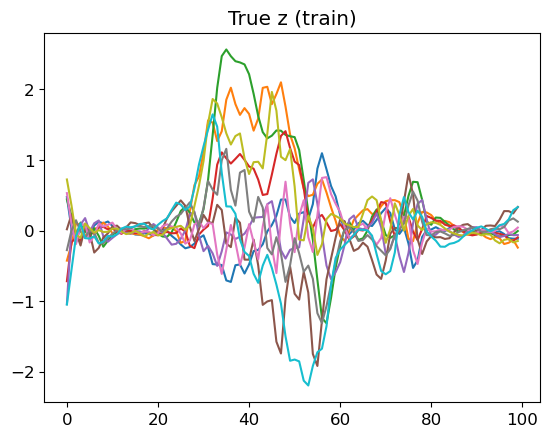

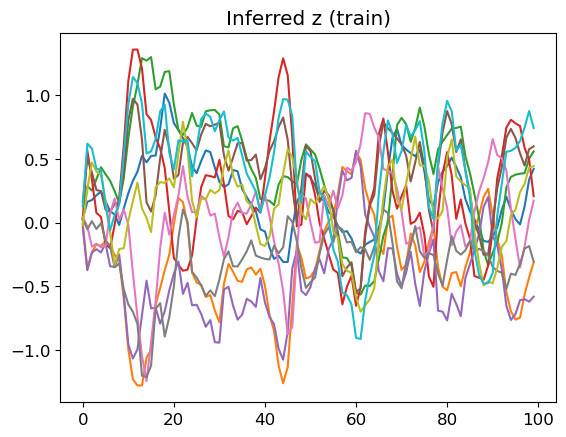

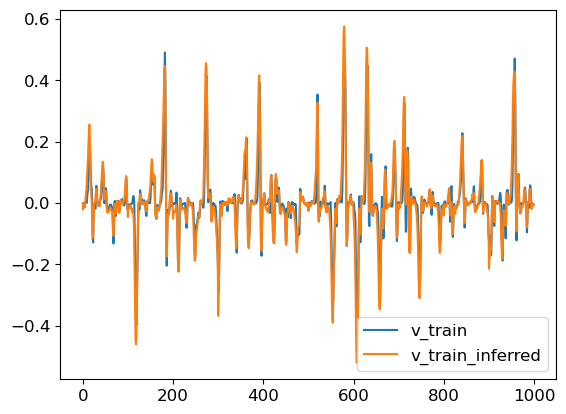

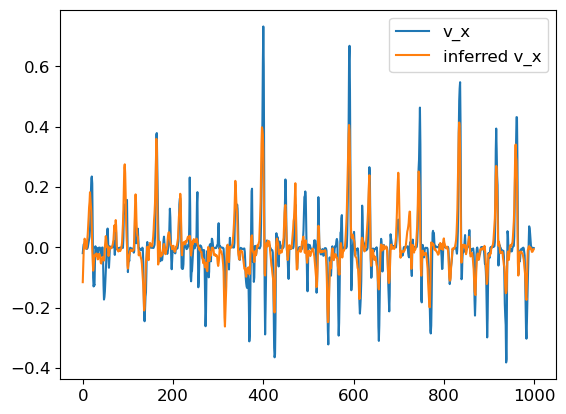

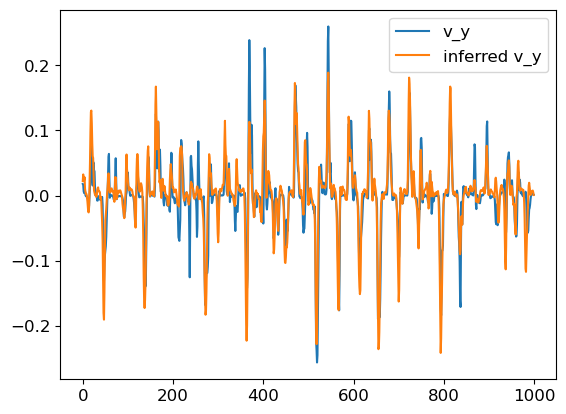

x test 0.6995448633846553 y test 0.6620506883644983 avg 0.6807977758745768
x train 0.833770932627493 y train 0.8647184871157749 avg 0.849244709871634
x test 0.6397466416551776 y test 0.6911805171083308 avg 0.6654635793817543 trial 0
x test 0.7301182187009931 y test 0.6518709006837986 avg 0.6909945596923959 trial 1
x test 0.6943474928328088 y test 0.6602446809691891 avg 0.677296086900999 trial 2
x test 0.7855958676948195 y test 0.6685252190966219 avg 0.7270605433957207 trial 3
x test 0.6353530885997678 y test 0.6290769237488703 avg 0.632215006174319 trial 4


In [23]:
for trial in range(1):
    if z_train is None:
        z_train = p.get_z_hat(v_train[trial, ...][None, ...].to(device), smoothing=smoothing).detach().cpu().numpy()
    plt.plot(z_train[0, :, :].T)
    # plt.plot(v_train[trial, ...].T * 20)
    plt.title('True z (train)')
    plt.show()

    plt.plot(z_train_inferred[trial, ...].T)
    plt.title('Inferred z (train)')
    plt.show()

if dataset == 'Doherty':
    start = 0
    stop = 1000
    plt.plot(v_train[:,0,:].flatten()[start:stop], label = 'v_train')
    plt.plot(v_train_inferred[:,0,:].flatten()[start:stop], label = 'v_train_inferred')
    plt.legend()
    plt.show()

big_show = False
if big_show:
    for trial in range(1):
        plt.figure(figsize=(15, 5))  # Adjust as needed
        # plt.imshow(_Y_train[trial].T)
        plt.imshow(Y_test[trial].T)
        plt.colorbar()
        plt.title('Spike train (test)')
        plt.show()
        plt.figure(figsize=(15, 5))  # Adjust as needed
        # plt.imshow(rec_model.get_x_tilde(rec_model.gen_model.Y).detach().cpu().numpy()[trial].T)
        pseudo_obs = rec_model.get_x_tilde(Y_test.to(device), only_x_tilde=False)
        x_tilde = pseudo_obs['x_tilde'].detach().cpu().numpy()[trial].T
        plt.imshow(x_tilde)
        # plt.imshow(rec_model.get_x_tilde(Tensor(_Y_test).to(device)).detach().cpu().numpy()[trial].T)
        plt.colorbar(orientation='horizontal')
        plt.title('x_tilde')
        plt.show()
        # rec_model.zero_mean_x_tilde = False
        print(rec_model.get_x_tilde(Y_test.to(device)).detach().cpu().numpy()[trial].shape)
        plt.plot(rec_model.get_x_tilde(Y_test.to(device)).detach().cpu().numpy()[trial].mean(axis=-1))
        plt.title('x_tilde mean')
        plt.show()
        plt.figure(figsize=(15, 5))  # Adjust as needed
        # plt.imshow(rec_model.gen_model.link_fn(model.C @ model.W @ Tensor(z_train[trial]).to(device) + rec_model.gen_model.d[:, None]).detach().cpu().numpy().T)
        plt.imshow(rec_model.gen_model.link_fn(gen_model.C @ gen_model.W @ Tensor(z_test_inferred[trial]).to(device) + rec_model.gen_model.d[:, None]).detach().cpu().numpy().T)
        plt.colorbar()
        plt.title('Firing rate')
        plt.show()

        if pseudo_obs['delta_R'] is not None:
            delta_R = pseudo_obs['delta_R'].detach().cpu().numpy() # (T, ntrials, x_dim)
            for t in range(10):
                plt.plot(delta_R[t, trial, :])
            plt.title('delta_R')
            plt.show()

            if not rec_model.gen_model.full_R:
                plt.plot(rec_model.gen_model.log_sigma_x.detach().cpu().numpy(), label='log_sigma_x')
                plt.legend()
                plt.show()

            new_R = rec_model.gen_model_R(pseudo_obs)[:, trial, ...].detach().cpu().numpy() # (T, x_dim, x_dim)
            R_diag = np.diagonal(new_R, axis1=-1, axis2=-2)
            print(R_diag.shape)
            for t in range(10):
                plt.plot(R_diag[t])
            plt.title('R_diag new')
            plt.show()
            R_orig = rec_model.gen_model_R(pseudo_obs=None).detach().cpu().numpy() # (x_dim, x_dim)
            R_diag_orig = np.diagonal(R_orig, axis1=-1, axis2=-2)
            print(R_diag_orig.shape)
            plt.plot(R_diag_orig)
            plt.title('R_diag orig')
            plt.show()
        if pseudo_obs['delta_W'] is not None:
            delta_W = pseudo_obs['delta_W'].detach().cpu().numpy()
            norms = []
            norms2 = []
            for _trial in range(5):
                norms.append([np.linalg.norm(delta_W[t, _trial] - delta_W[0, _trial], ord='fro') for t in range(16)])
                norms2.append([np.linalg.norm(delta_W[t, _trial], ord='fro') for t in range(16)])
            norms = np.array(norms)
            plt.plot(norms.T)
            plt.title('Frobenius norm of delta_W with respect to first time point')
            plt.show()
            norms2 = np.array(norms2)
            plt.plot(norms2.T)
            plt.title('Frobenius norm of delta_W with respect to true W')
            plt.show()
            
            for t in [0,8,15]:
                plt.figure(figsize=(15, 5))  # Adjust as needed
                # plt.imshow(delta_W[t, trial].T)
                plt.imshow(rec_model.gen_model.W[0].detach().cpu().numpy().T + delta_W[t, trial].T)
                plt.colorbar(orientation='horizontal')
                plt.title('final W')
                plt.show()

# cw_v = np.load('KF.npy')
if dataset == '4g10':
    for trial in range(5):
        plt.rcParams['font.size'] = 12
        plt.plot(v_test[trial,0,:], label = r'True $v_x$', color='red')
        plt.plot(v_test[trial,1,:], label = r'True $v_y$', color='blue')
        plt.plot(v_test_inferred[trial,0,:], label = r'Joint model $v_x$', color='red', linestyle='dotted')
        plt.plot(v_test_inferred[trial,1,:], label = r'Joint model $v_y$', color='blue', linestyle='dotted')
        # plt.plot(__v[trial,0,:], label = r'Linear KF $v_x$', color='red', linestyle='dashed')
        # plt.plot(__v[trial,1,:], label = r'Linear KF $v_y$', color='blue', linestyle='dashed')
        plt.xlabel('Time bin')
        plt.ylabel('Velocity')
        plt.title('Test Trial {}'.format(trial+1))
        
        # plt.plot(cw_v[0,trial,:], label = 'KF x', color='red', linestyle='dashed')
        # plt.plot(cw_v[1,trial,:], label = 'KF y', color='blue', linestyle='dashed')
        plt.legend()
        # if trial in [0, 4]:
        #     plt.savefig(f'trial_{trial}_v_center_out.png')
        plt.show()
elif dataset == 'Doherty':
    # trials = list(range(40, 57))
    trials = list(range(1))
    plt.plot(v_test[trials,0,:].flatten(), label = 'v_x')
    plt.plot(v_test_inferred[trials,0,:].flatten(), label = 'inferred v_x')
    plt.legend()
    plt.show()

    plt.plot(v_test[trials,1,:].flatten(), label = 'v_y')
    plt.plot(v_test_inferred[trials,1,:].flatten(), label = 'inferred v_y')
    plt.legend()
    plt.show()
    pass

x_test_score = r2_score(v_test[:,0,:].flatten(), v_test_inferred[:,0,:].flatten())
y_test_score = r2_score(v_test[:,1,:].flatten(), v_test_inferred[:,1,:].flatten())
print('x test', x_test_score, 'y test', y_test_score, 'avg', (x_test_score + y_test_score)/2)

# calculate R2 on train data
x_train_score = r2_score(v_train[:,0,:].flatten(), v_train_inferred[:,0,:].flatten())
y_train_score = r2_score(v_train[:,1,:].flatten(), v_train_inferred[:,1,:].flatten())
print('x train', x_train_score, 'y train', y_train_score, 'avg', (x_train_score + y_train_score)/2)

if dataset == 'Doherty':
    for trial in range(v_test_inferred.shape[0]):
        x_test_score = r2_score(v_test[trial,0,:], v_test_inferred[trial,0,:])
        y_test_score = r2_score(v_test[trial,1,:], v_test_inferred[trial,1,:])
        print('x test', x_test_score, 'y test', y_test_score, 'avg', (x_test_score + y_test_score)/2, 'trial', trial)

# x_test_score_cw = r2_score(hand_test[:,0,:].flatten(), cw_v[0].flatten())
# y_test_score_cw = r2_score(hand_test[:,1,:].flatten(), cw_v[1].flatten())
# print('x test cw', x_test_score_cw, 'y test cw', y_test_score_cw, 'avg cw', (x_test_score_cw + y_test_score_cw)/2)

In [24]:
# # A = Tensor(np.load('A.npy')).to(device)
# # W = Tensor(np.load('4G10D.npy')).to(device)
# # Q = Tensor(np.load('Q.npy')).to(device)
# # R = Tensor(np.load('4G10S.npy')).to(device)
# # mu0 = Tensor(np.load('mu0.npy')).to(device)
# # Sigma0 = Tensor(np.load('Sigma0.npy')).to(device)
# y = m.Y - m.Y.mean(dim=(0,-1), keepdim=True)
# y = y.transpose(-1, -2).detach().cpu().numpy() # (ntrials, T, N)

# z = m.z.transpose(-1, -2).detach().cpu().numpy() # (ntrials, T, b)

# outer_yz = (y[..., None] @ z[..., None, :]).sum(axis=(0, 1)) # (N, b)
# outer_zz = (z[..., None] @ z[..., None, :]).sum(axis=(0, 1)) # (b, b)
# W = outer_yz @ np.linalg.inv(outer_zz) # (N, b)

# outer_yy = (y[..., None] @ y[..., None, :]).sum(axis=(0, 1)) # (N, N)
# outer_zy = (z[..., None] @ y[..., None, :]).sum(axis=(0, 1)) # (b, N)
# R = (outer_yy - W @ outer_zy)/(m.T * m.ntrials) # (N, N)

# # W = W.detach().cpu().numpy()
# # R = R.detach().cpu().numpy()

# W = Tensor(W).to(device)
# R = Tensor(R).to(device)

# A = m.A[0]
# # W = m.W[0]
# Q = m.Q[0]
# # R = m.R[0]
# mu0 = m.mu0[0]
# Sigma0 = m.Sigma0[0]
# _, _, Ks, Cs = general_kalman_covariance(A=A, W=W, Q=Q, R=R, b=10, x_dim=162, Sigma0=Sigma0, T=80)
# x_hat = Tensor(Y_test).to(device) - torch.mean(Tensor(Y_test).to(device), dim=(0,2), keepdim=True)[None, ...]
# plt.plot(x_hat[0,0,0, :].detach().cpu().numpy())
# _ , mus_smooth, _ = general_kalman_means(A=A, W=W, b=10, mu0=mu0, x_hat=x_hat, Ks=Ks, Cs=Cs)
# mus_smooth = mus_smooth.squeeze(1) # (T_test, ntrials, b)
# mus_smooth = mus_smooth.detach().cpu().numpy().transpose(1, 2, 0)
# C = p.W.detach().cpu().numpy()
# __v = C[None, ...] @ mus_smooth
# print(__v.shape)
# # hand_test = np.load('new_data.npz')['hand_test']
# # hand_test = hand_test.transpose(1,0,2)
# print('x test', r2_score(v_test[:,0,:].flatten(), __v[:,0,:].flatten()))
# print('y test', r2_score(v_test[:,1,:].flatten(), __v[:,1,:].flatten()))
# print('avg', (r2_score(v_test[:,0,:].flatten(), __v[:,0,:].flatten()) + r2_score(v_test[:,1,:].flatten(), __v[:,1,:].flatten()))/2)

In [25]:
F = np.load('NB_co_long_bi_newCD_rec_firing_rates_test.npy')
print(F.shape)
Ypred = F[0].T
print(Ypred.shape)

(1, 200, 10000)
(10000, 200)


In [26]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
binsize = 25 # binsize in ms
T_trial = 0.025 # 25ms
start = 12800
data_len = 10000
timepoints = np.arange(start, data_len+start) #subsample ~40 seconds of data so things will run somewhat quicker
# print(data['Y'].shape)
fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
Y = fit_data['Y'] # these are the actual recordings and is the input to our model
targets = fit_data['targets'] # these are the target locations
locs = fit_data['locs'] # these are the hand positions

# Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 2, :] #subsample highly active neurons so things will run a bit quicker
Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 0, :]
# print(Y.shape)
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]

ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior

plotting decoding
0.8038480313528188


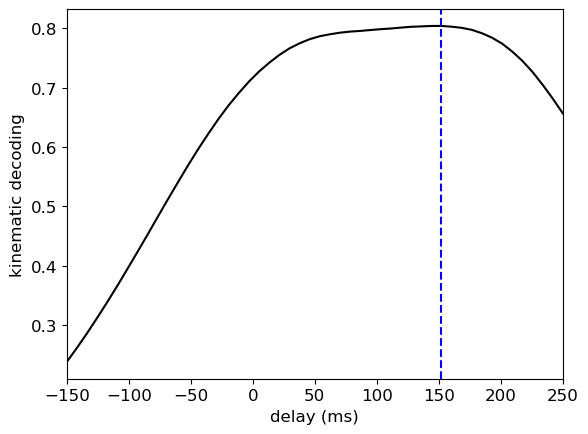

In [27]:
delays = np.linspace(-150, 250, 50) # consider different behavioral delays
performance = np.zeros((len(delays), 2)) # model performance
for idelay, delay in enumerate(delays):
    vels = cs(ts+delay, 1) # velocity at time+delay
    for itest, Ytest in enumerate([Ypred]): # bGPFA
      # regs = [Ridge(alpha=1e-3).fit(Ytest[::2, :], vels[::2, i]) for i in range(2)] # fit x and y vel on half the data
      # scores = [regs[i].score(Ytest[1::2, :], vels[1::2, i]) for i in range(2)] # score x and y vel on the other half
      regs = [Ridge(alpha=1e-3).fit(Ytest[:data_len//2, :], vels[:data_len//2, i]) for i in range(2)] # fit x and y vel on half the data
      scores = [regs[i].score(Ytest[data_len//2:, :], vels[data_len//2:, i]) for i in range(2)] # score x and y vel on the other half
      performance[idelay, itest] = np.mean(scores) # save performance
print('plotting decoding')
plt.figure()
plt.plot(delays, performance[:, 0], 'k-')
plt.axvline(delays[np.argmax(performance[:, 0])], color = 'b', ls = '--')
# x on maxima
print(max(performance[:, 0]))
plt.xlim(delays[0], delays[-1])
plt.xlabel('delay (ms)')
plt.ylabel('kinematic decoding')
plt.show()